In [1]:
"""Improve name detector with both accuracy and inference time
"""

import sys
import os

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Make this script able to call lib module from parent level
sys.path.append(os.getcwd())
sys.path.append('../../line_detector/')

from lib.fast_rcnn.config import cfg,cfg_from_file
import detector

DATA_DIR = '/home/ducna/share/Data/processed/cropped'

In [2]:
# Config file
cfg_from_file('../../line_detector/text.yml')
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

# Load pb graph
with tf.gfile.FastGFile('../../line_detector/models/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

sess.run(tf.global_variables_initializer())

In [5]:
# Load model
from sklearn.externals import joblib

gbc = joblib.load('/home/ducna/share/Classifier/region/gbc.sav')

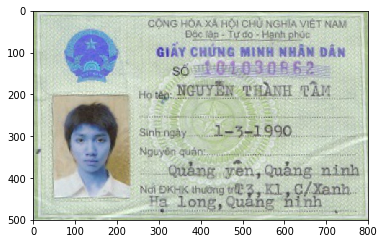

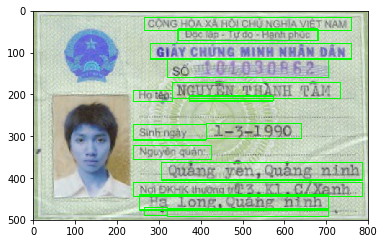

In [6]:
# Random a picture
import random

img_path = os.path.join(DATA_DIR, 
                        random.choice(os.listdir(DATA_DIR)))
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()


def draw_boxes(img, boxes, color=(0, 255, 0), title=None):
    """Draw boxes in image given coordinates
    """
    clone = np.copy(img)
    for box in boxes:
        cv2.rectangle(clone, box[0], box[1], color, 2)

    if title:
        plt.title(title)
        
    plt.imshow(clone)
    plt.show()
    
    return clone


# Detect lines and show result
boxes = detector.query_pb(sess, cfg, img)

_ = draw_boxes(img, boxes)

In [9]:
from collections import OrderedDict
import pandas as pd

boxes_dict = OrderedDict({
    'x1': [box[0][0] for box in boxes], 
    'y1': [box[0][1] for box in boxes], 
    'x2': [box[1][0] for box in boxes], 
    'y2': [box[1][1] for box in boxes], 
})
boxes_df = pd.DataFrame.from_dict(boxes_dict)
boxes_df

,x1,y1,x2,y2
0,333,172,733,210
1,266,17,760,48
2,413,269,640,305
3,320,118,706,161
4,373,204,573,216
5,320,473,706,492
6,240,322,426,355
7,240,191,333,218
8,240,410,786,444
9,306,363,786,404


CPU times: user 1.52 s, sys: 76 ms, total: 1.59 s
Wall time: 120 ms


/home/hoanghiep/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


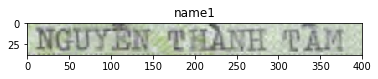

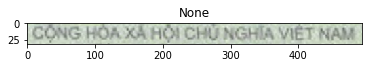

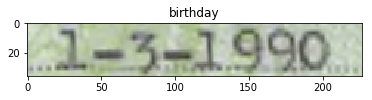

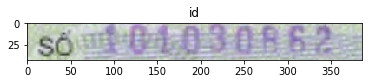

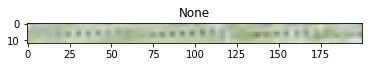

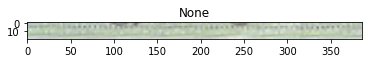

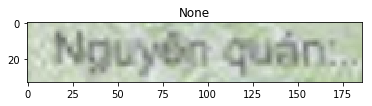

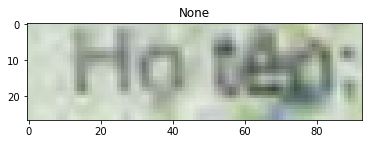

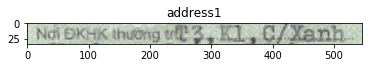

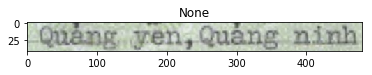

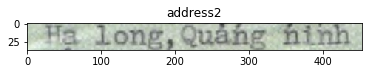

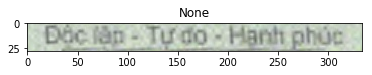

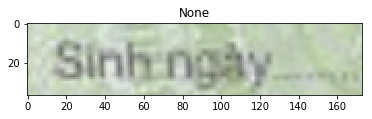

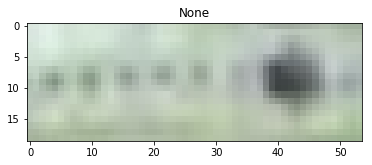

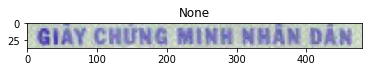

In [11]:
%time labels = gbc.predict(boxes_df)
for i, box in enumerate(boxes):
    (x1, y1), (x2, y2) = box
    plt.imshow(img[y1:y2, x1:x2])
    plt.title(labels[i])
    plt.show()